<a href="https://colab.research.google.com/github/moustafa-7/1-3_convolutional-Encoder_viterbi-decoder/blob/master/1_3_conv_encoders_and_viterbi_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt

In [0]:
def twoDoneD(arr):
  arr = np.asarray(arr);
  R, C = arr.shape
  arr = arr.reshape(R * C)
  return arr


In [0]:
def oneDtwoD(arr,rows,cols):
    arr = np.asarray(arr)
    arr = arr.reshape(rows, cols)
    return arr


In [0]:
def preTransmitting(stream):
  s = np.asarray(stream.copy())
  s[s == 0] = -1
  return s

In [0]:
def postReceiving(stream):
  s = np.asarray(stream.copy())
  s[s <= 0] = int(0)
  s[s > 0] = int(1)
  return s

In [0]:
def int_to_bin(int_list):
  output = [] 
  for i in range(len(int_list)):
    x = [int(z) for z in f'{int_list[i]:08b}']
    output.extend(x)
  
  return output
  

In [155]:
int_to_bin([2,8])

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [0]:
def bin_to_int(bin_list):
  int_list =[]
  for i in range(len(bin_list)//8):
    chunk = bin_list[i*8:(i+1)*8]
    chunk = ''.join(map(str,chunk))
    int_list.append(int(chunk,2))
  return int_list
    

In [161]:
print(bin_to_int([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]))

[2, 8]


In [0]:
def addNoise(SNR, stream):
  return list(np.random.normal(scale=np.sqrt(1/SNR), size=len(stream)) + np.asarray(stream))


In [0]:
def MSE(received_img, origional_img):
  rows, cols = origional_img.shape
  residual = origional_img - received_img
  square_error = np.sum(np.square(residual))

  return square_error/(rows*cols)


In [0]:
import numpy as np

def one_time_encoder(s_0, s_1, new_bit):
    output = [0,0,0]
    output[0] = new_bit^s_0
    output[1] = s_1
    output[2] = new_bit ^s_1
    
    return output



def encoder(input_bits):

    encoding = []
    
    bits = [0,0] + input_bits

    for i in range(len(bits)-2):
        encoding += one_time_encoder(bits[i], bits[i+1], bits[i+2])

    del input_bits

    return encoding


def one_bit_dist(bit_1, bit_2):
    return 0 if bit_1 == bit_2 else 1


def get_next_state(current_state, input_bit):
    next_state = [input_bit, current_state[0]]
    return next_state



def decoder(encoded_stream):
    
    
    states = {0: [0,0], 1:[0,1], 2:[1,0], 3:[1,1]}

    # create list layers one for each step

    steps = []
    for i in range(int(len(encoded_stream)/3)+1):
        step = []
        for i in range(4):
            step.append({'cost': np.inf, 'prev_s': -1, 'bit_input': -1})
        
        steps.append(step)

    # forcing the initial state to be 0
    steps[0][0]['cost'] = 0
    steps[0][0]['prev_s'] = 0
    steps[0][0]['bit_input'] = 0


    for i in range(len(steps)-1):
        block_received = encoded_stream[i*3:(i+1)*3]

        for s in range(4):
            if (steps[i][s]['prev_s'] == -1):
                continue

            current_bits = states[s]

            new_state_0 = get_next_state(current_bits,0)
            new_state_1 = get_next_state(current_bits,1)

            new_s_0 = new_state_0[0]*2 + new_state_0[1]
            new_s_1 = new_state_1[0]*2 + new_state_1[1]


            encoded_chunk_0 =  one_time_encoder(current_bits[1], current_bits[0], 0)
            encoded_chunk_1 =  one_time_encoder(current_bits[1], current_bits[0], 1)

            cost_0 = sum([one_bit_dist(encoded_chunk_0[k],block_received[k]) for k in range(len(encoded_chunk_0))])
            cost_1 = sum([one_bit_dist(encoded_chunk_1[k],block_received[k]) for k in range(len(encoded_chunk_1))])
        

            if steps[i+1][new_s_0]['cost'] > steps[i][s]['cost'] + cost_0:
                steps[i+1][new_s_0]['cost'] = steps[i][s]['cost'] + cost_0
                steps[i+1][new_s_0]['prev_s'] = s
                steps[i+1][new_s_0]['bit_input'] = 0

            if steps[i+1][new_s_1]['cost'] > steps[i][s]['cost'] + cost_1:
                steps[i+1][new_s_1]['cost'] = steps[i][s]['cost'] + cost_1
                steps[i+1][new_s_1]['prev_s'] = s
                steps[i+1][new_s_1]['bit_input'] = 1


    best_state = min(steps[-1], key = lambda x: x['cost'])
    res = [best_state['bit_input']]
    prev_s = best_state['prev_s']
    prev_state = steps[-2][prev_s]

    steps = steps[:-1]
    steps.reverse()
    for i in range(len(steps)-1):
        res.append(prev_state['bit_input'])
        prev_state = steps[i+1][prev_state['prev_s']]

    res.reverse()


    return res

(512, 512)


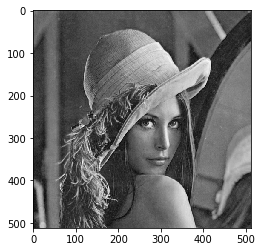

In [275]:
image = cv2.imread('Lena.jpg')
image = image[:,:,0]
image = np.asarray(image)
# image = np.zeros((100,100))
# image[:50,:] = 255
print(image.shape)
plt.imshow(image, cmap = "gray")

# **No Encoding**

In [0]:
one_d_img = list(twoDoneD(image))
bin_img = int_to_bin(one_d_img)

In [0]:
bin_img = preTransmitting(bin_img)
rx = addNoise(1,bin_img)
rx = postReceiving(rx)

In [278]:
rx[0]

1.0

In [0]:
r_img = bin_to_int([int(x) for x in rx])
r_img = oneDtwoD(r_img,512,512)

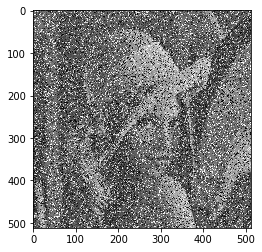

In [280]:
plt.imshow(r_img, cmap= "gray")

In [281]:
print(MSE(r_img, image))

3071.1613006591797


# **SNR = 1**

In [0]:
one_d_img = list(twoDoneD(image))
bin_img = int_to_bin(one_d_img)
encoded = encoder(bin_img)
encoded = preTransmitting(encoded)


In [283]:
len(encoded)

6291456

In [0]:
rx = addNoise(1,encoded)

In [0]:
rx = postReceiving(rx)

In [0]:
one_d_img_r = decoder(rx)

In [0]:
r_img = bin_to_int(one_d_img_r)

In [0]:
r_img = oneDtwoD(r_img,512,512)

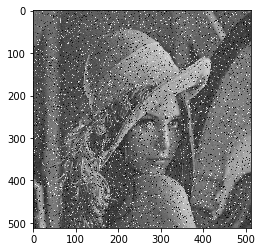

In [289]:
plt.imshow(r_img, cmap= "gray")

In [290]:
print(MSE(r_img, image))

995.3907051086426


# **SNR = 2**

In [0]:
rx = addNoise(2,encoded)

In [0]:
rx = postReceiving(rx)

In [0]:
one_d_img_r = decoder(rx)

In [0]:
r_img = bin_to_int(one_d_img_r)

In [0]:
r_img = oneDtwoD(r_img,512,512)

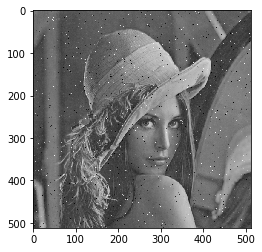

In [296]:
plt.imshow(r_img, cmap= "gray")

In [297]:
print(MSE(r_img, image))

124.28164672851562


# **SNR = 5**

In [0]:
rx = addNoise(5,encoded)

In [0]:
rx = postReceiving(rx)

In [0]:
one_d_img_r = decoder(rx)

In [0]:
r_img = bin_to_int(one_d_img_r)

In [0]:
r_img = oneDtwoD(r_img,512,512)

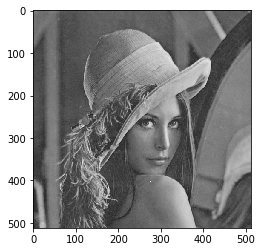

In [303]:
plt.imshow(r_img, cmap= "gray")

In [304]:
print(MSE(r_img, image))

0.5276947021484375
